# Aquapointer Density File Slicing Example

This is a demonstration of the `Slicing` module in Aquapointer, for processing 3D-RISM density files into useful objects, namely `DensityCanvas` objects. The properties of the resulting `DensityCanvas` objects include parameters, which are taken as inputs in the QUBO solution workflow.

In [1]:
import sys
from pathlib import Path
BASE_PATH = str(Path.cwd().parent.parent)
sys.path.append(BASE_PATH)

from copy import deepcopy
import numpy as np
from numpy.linalg import norm
import scipy.ndimage as ndi
from aquapointer import analog
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.slicing import density_file_to_grid, density_slices_by_plane_and_offsets, density_slices_by_planes, density_origin, density_point_boundaries
import matplotlib.pyplot as plt

### 1. Load the 3D-RISM density file into a [`grid`](https://griddataformats.readthedocs.io/en/latest/gridData/formats/OpenDX.html#) object, which can be converted into a numpy array and sliced into 2D arrays, which are then converted into density canvases.

In [2]:
grid = density_file_to_grid("../data/3D-RISM_densities/1NNC/prot_3drism.O.1.dx")

In [3]:
print(density_origin(grid))
print(density_point_boundaries(grid))

[ 6.694 -3.659 41.76 ]
[46.694 36.341 81.76 ]


## 2. Define slicing planes. 
One way to do this is by defining an array of 3 points and (optionally) offsets to create parallel slicing planes. 

In [4]:
points = np.array([[0, 0, 10], [1, 0, 10], [0, 1, 10]]) + np.array([density_origin(grid)] * 3)
canvases = density_slices_by_plane_and_offsets(grid, points=points, offsets=[10, 20])

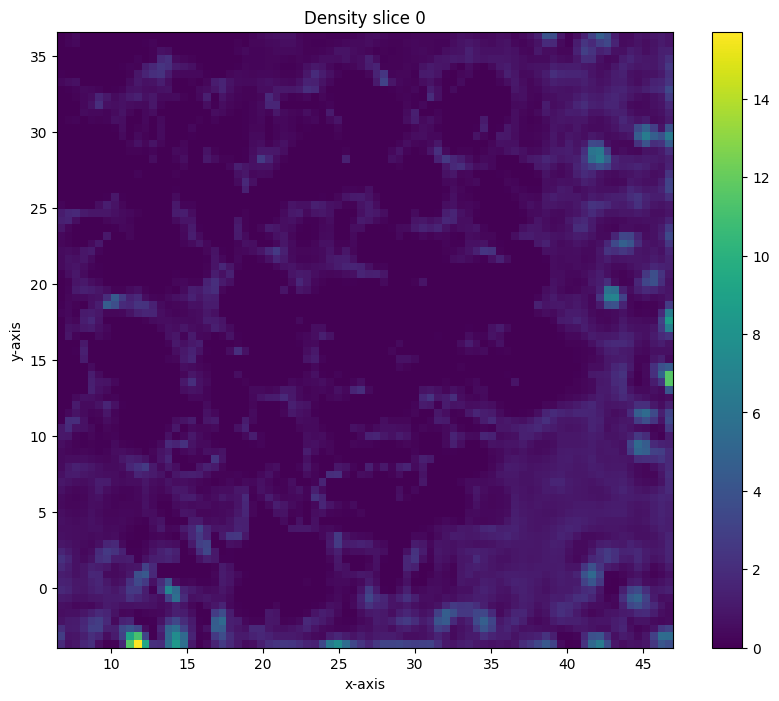

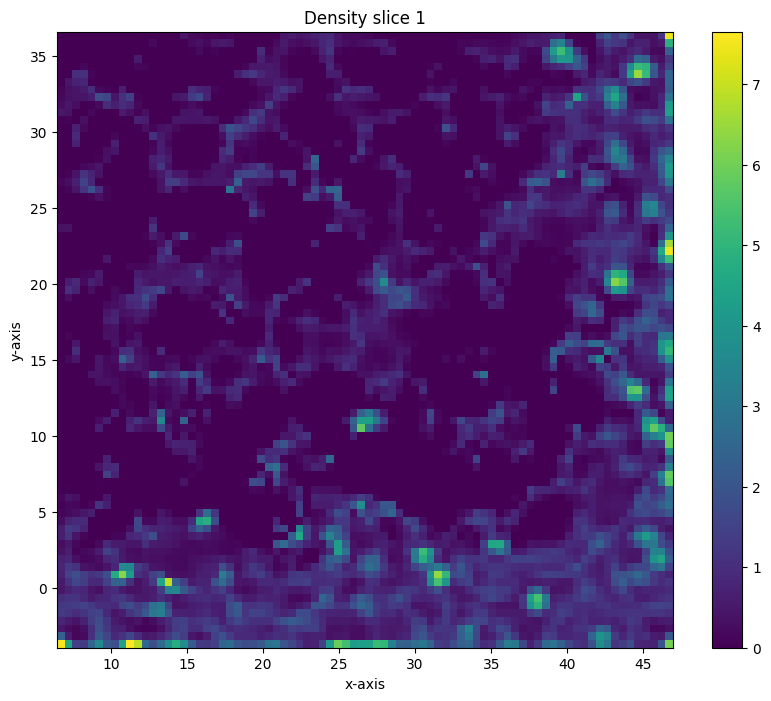

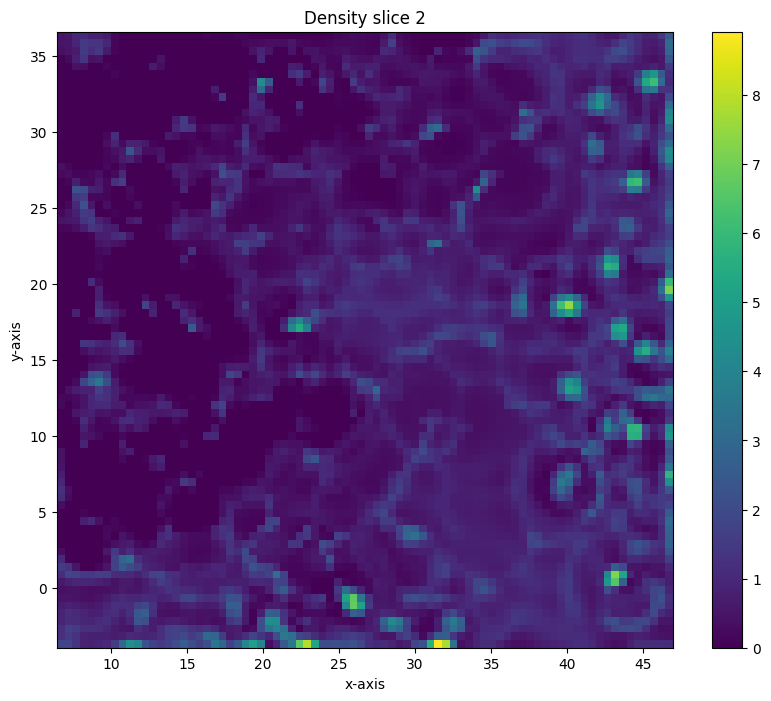

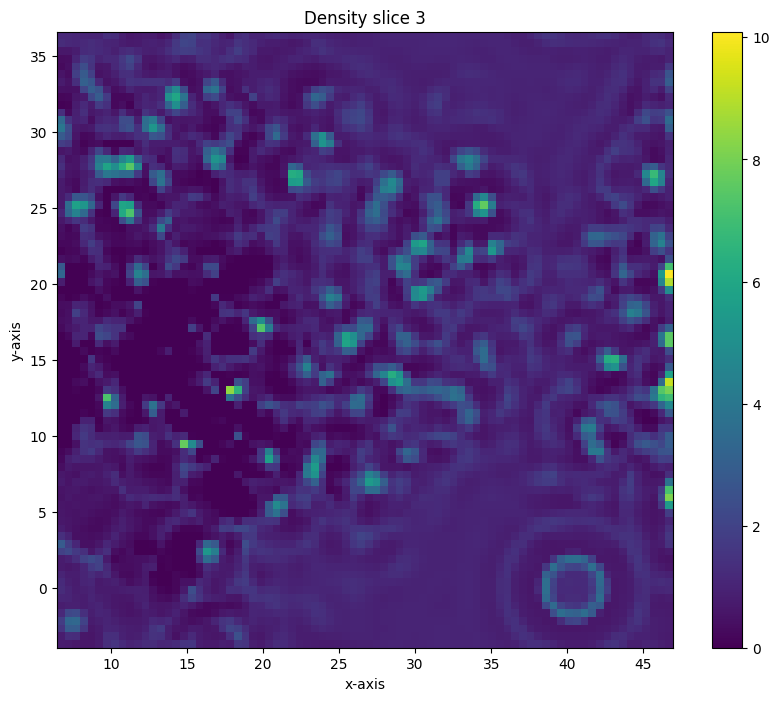

In [5]:
for c, canvas in enumerate(canvases):
    canvas.draw(title=f"Density slice {c}")

## 3. (Optional) Density canvases can be filtered by a user-defined filter function (or a function from another package, such as `scipy.ndimage.laplace`).

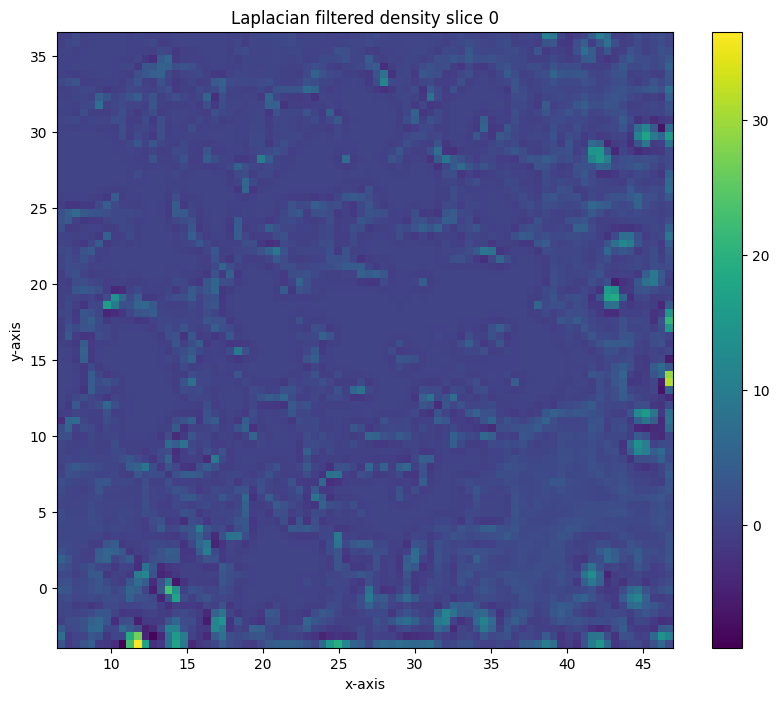

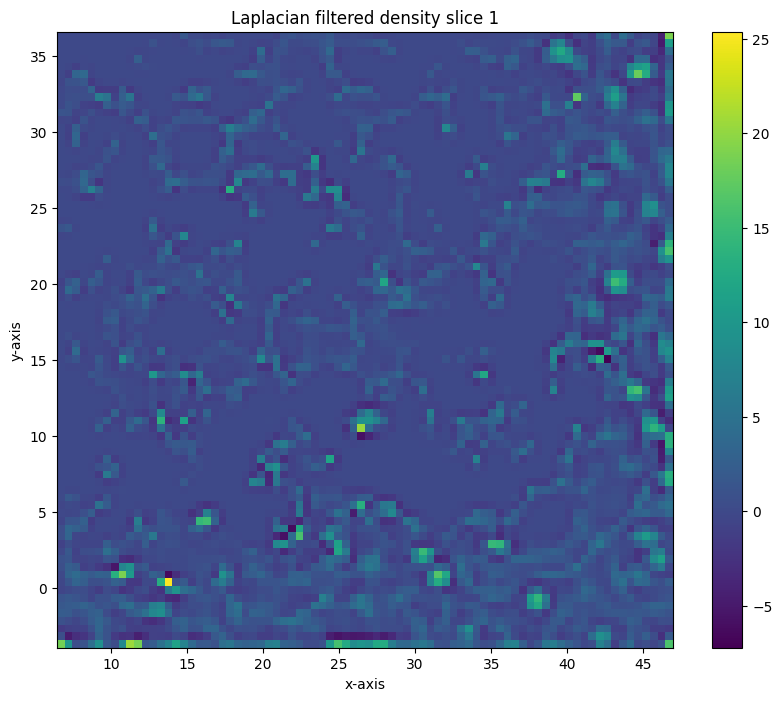

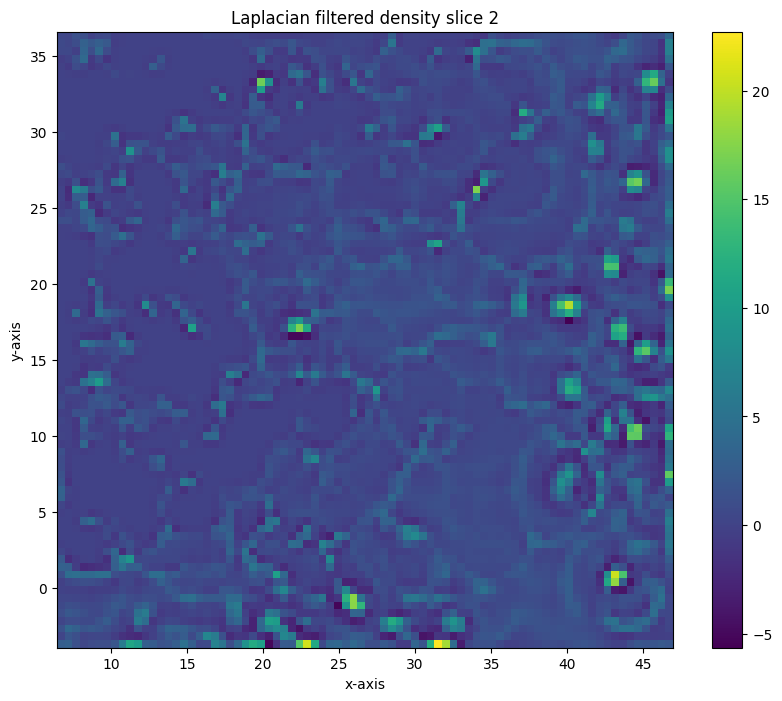

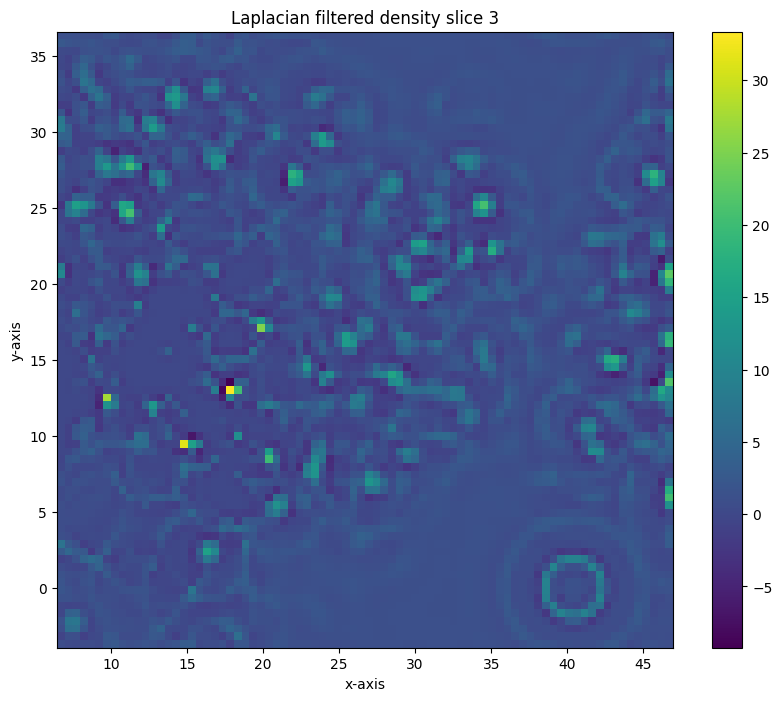

In [6]:
for c, canvas in enumerate(canvases):
    filtered = deepcopy(canvas)
    filter_fn = lambda x, sigma: -ndi.gaussian_laplace(x, sigma)
    sigma = float(0.5)
    filtered.filter_density(filter_settings={"filter_function": filter_fn, "sigma": sigma})
    filtered.draw(title=f"Laplacian filtered density slice {c}")

## 4. (Optional) Density canvases can be cropped to focus on a particular region. Just specify the center and the x and y dimensions of the bounding box 

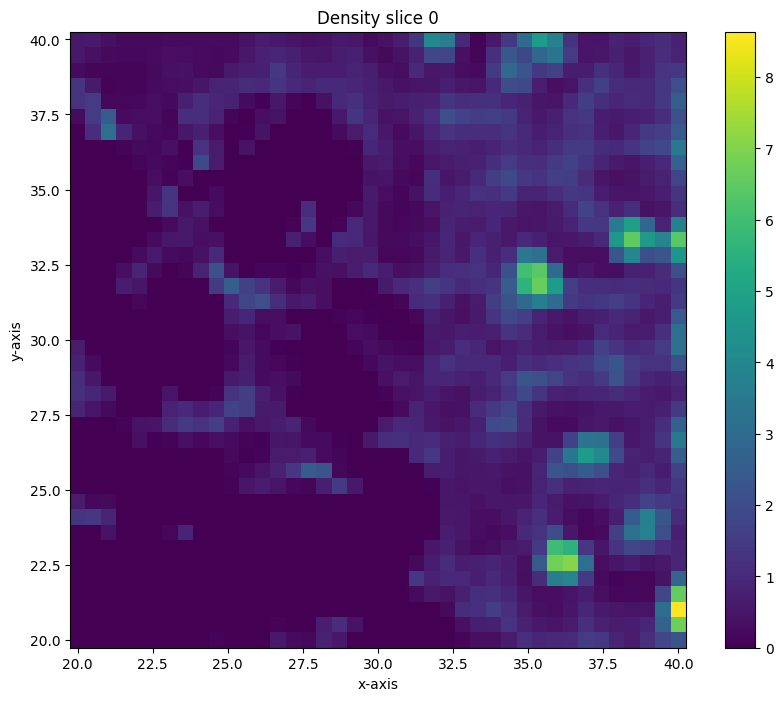

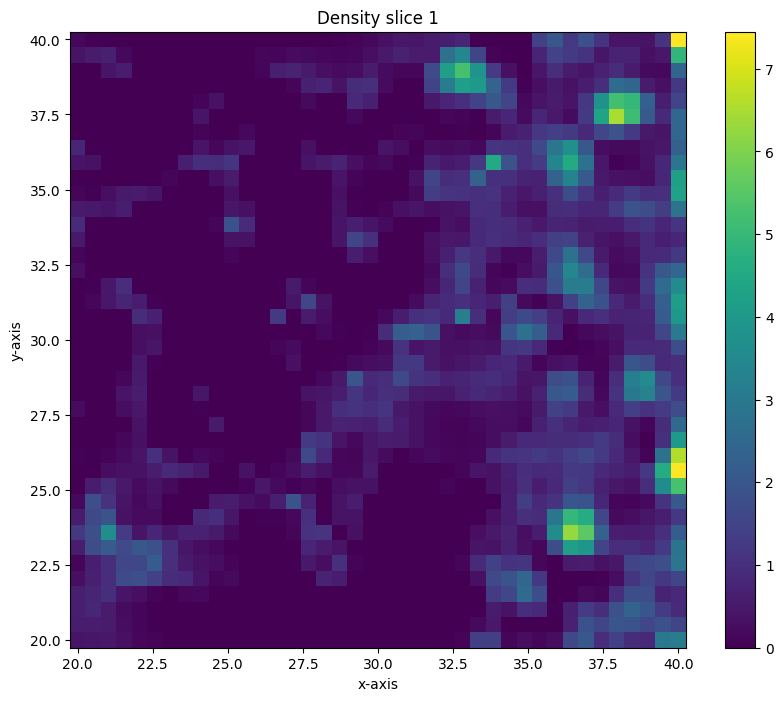

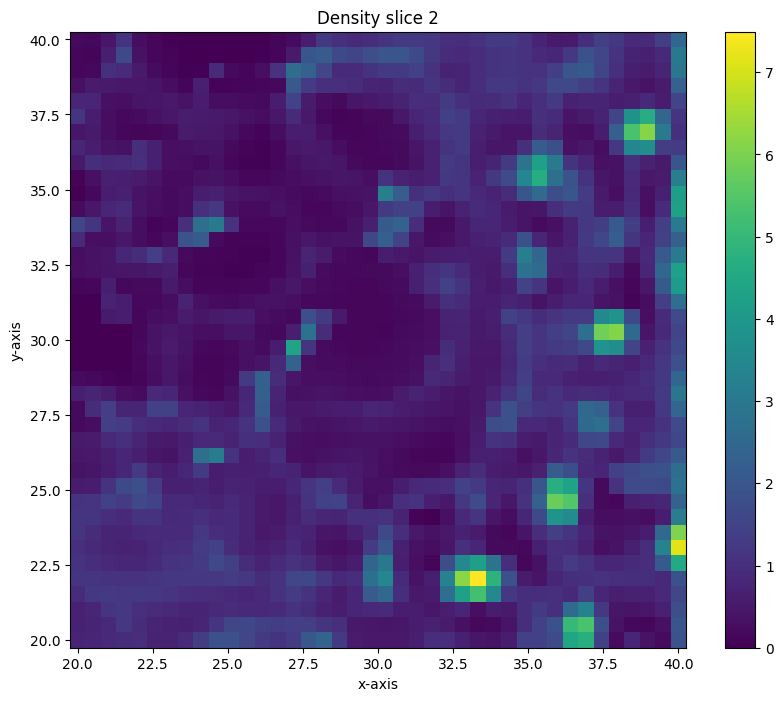

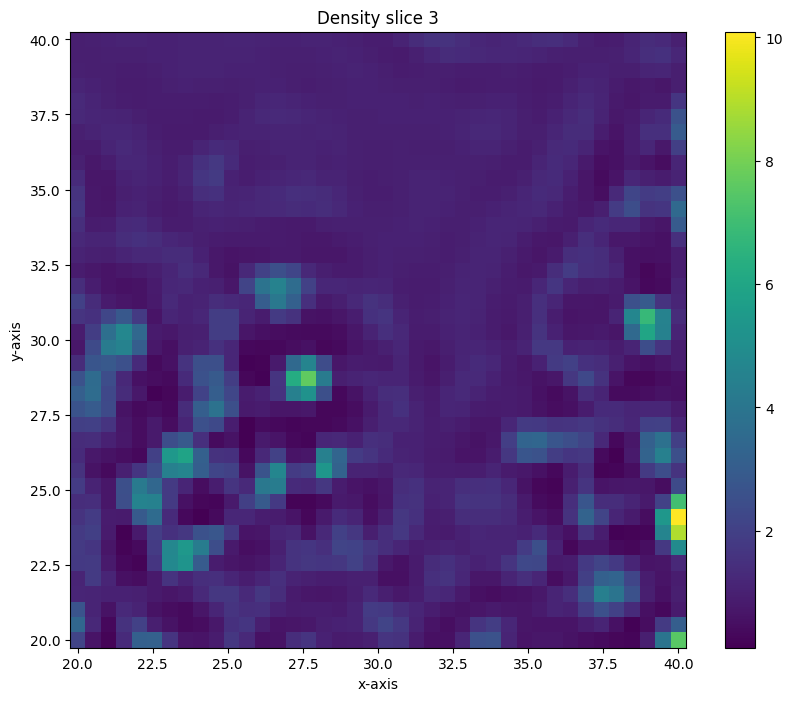

In [7]:
cropped_canvases = deepcopy(canvases)

for c, canvas in enumerate(canvases):
    cropped = deepcopy(canvas)
    cropped.crop_canvas((40, 40), (20, 20))
    cropped.draw(title=f"Density slice {c}")

Alternatively, it is possible to define slicing planes by a list of arrays containing the 3 point definition of each slicing plane.

In [8]:
og = density_origin(grid)
points_1nnc = [
            np.array([og + np.array([5, 10, 8]),  og + np.array([6, 10, 8]), og + np.array([5, 11, 7])]),             
            np.array([og + np.array([15, 16, 20]), og + np.array([16, 16, 20]), og + np.array([15, 17, 19])]), 
            np.array([og + np.array([25, 22, 32]), og + np.array([26, 22, 32]), og + np.array([25, 23, 31])])
            ]
canvases_1nnc = density_slices_by_planes(grid, points_1nnc)

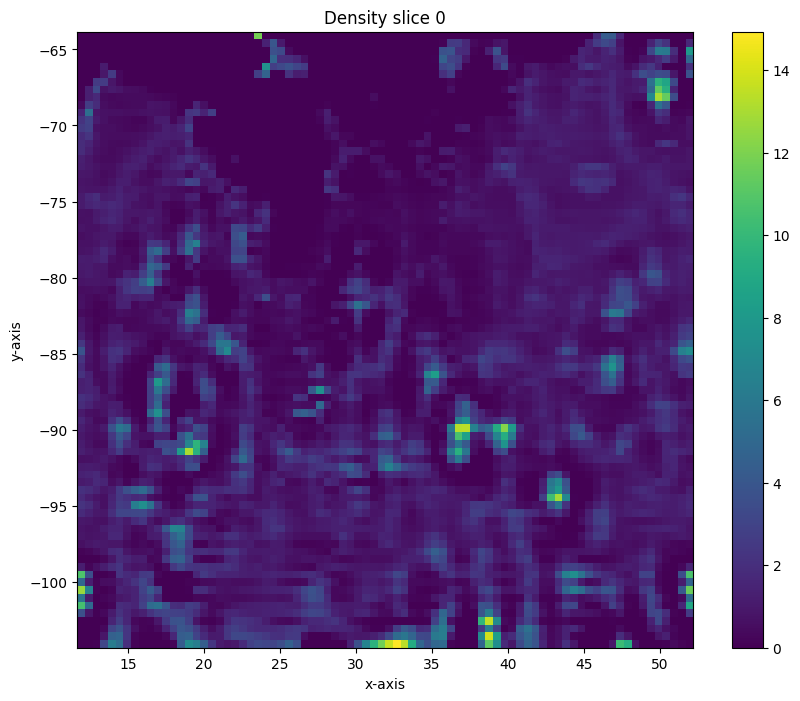

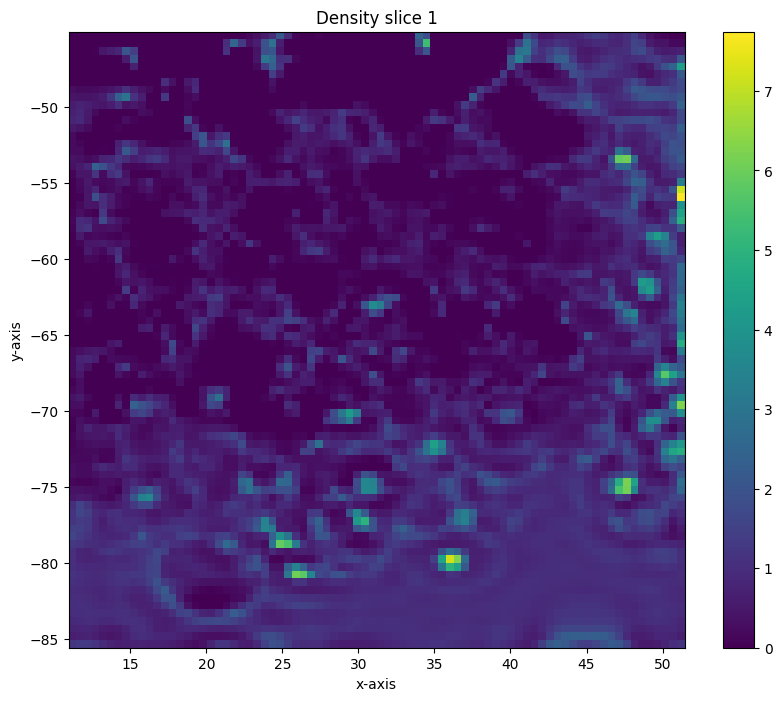

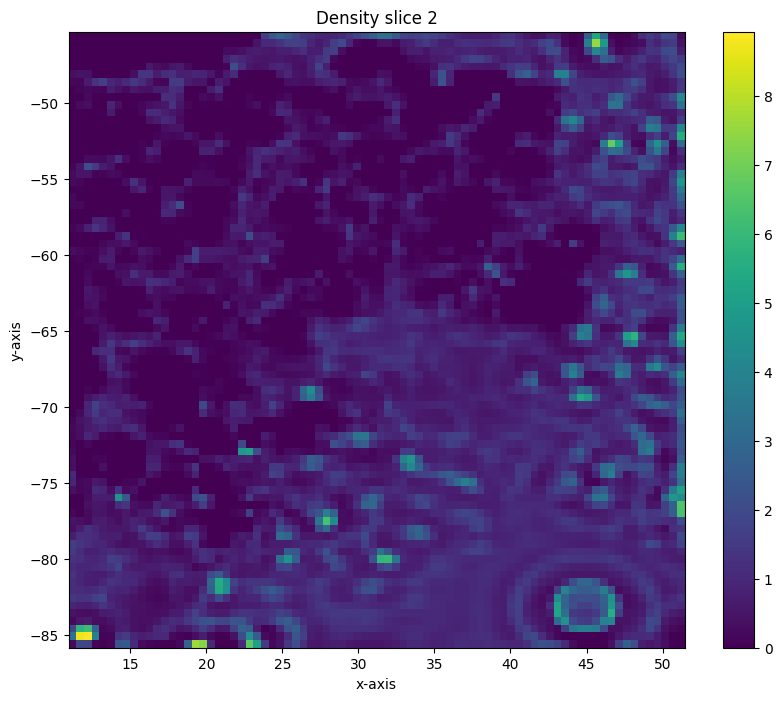

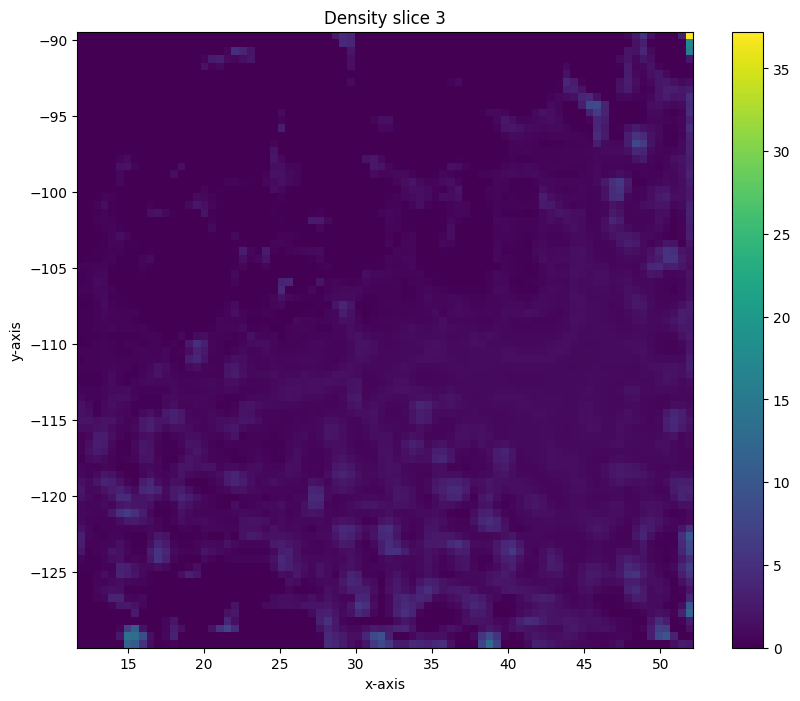

In [9]:
for c, canvas in enumerate(canvases_1nnc):
    canvas.draw(title=f"Density slice {c}")

### A second example starting with a 3D-RISM density file.

In [10]:
grid_bd = density_file_to_grid("../data/3D-RISM_densities/bromoD/prot_3drism.O.1.dx")

In [11]:
print(density_origin(grid_bd))
print(density_point_boundaries(grid_bd))

[101.906 -26.182 -20.756]
[141.906  13.818  19.244]


Try slicing in the Y direction.

In [12]:
points_bd = np.array([[0, 5, 0], [1, 5, 0], [0, 5, -1]]) + np.array([density_origin(grid_bd)] * 3)
canvases_bd = density_slices_by_plane_and_offsets(grid_bd, points=points_bd, offsets=np.linspace(5, 30, 6, dtype=int))

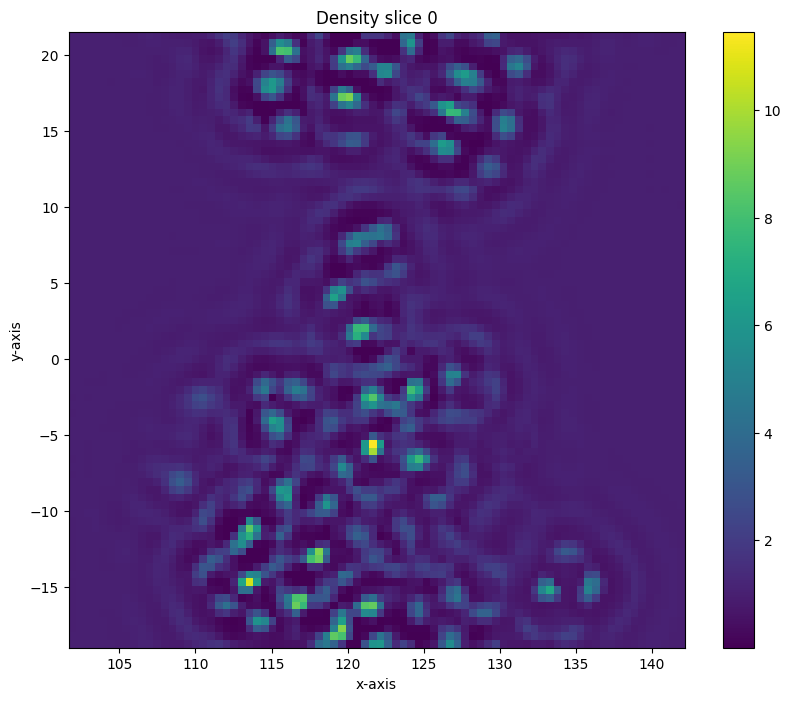

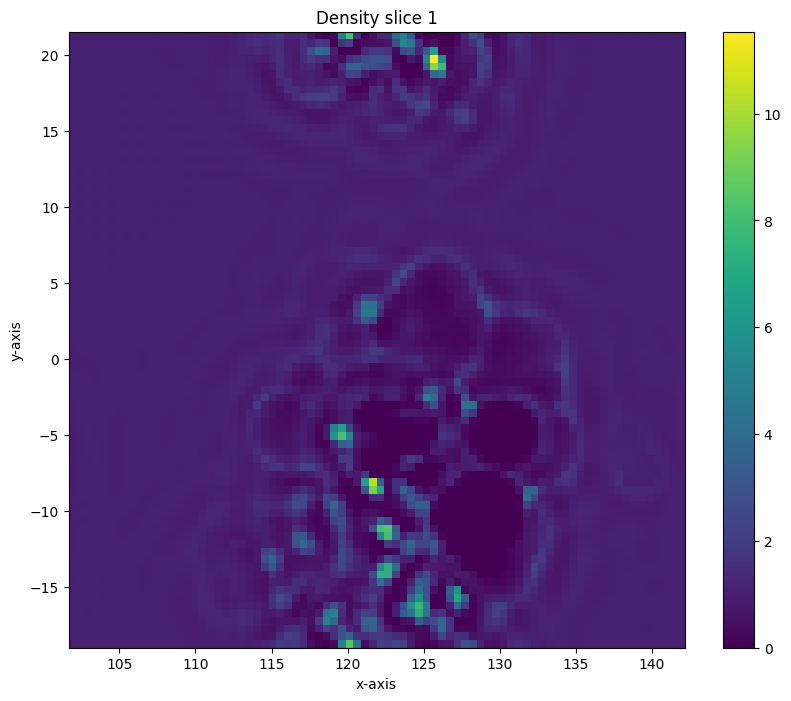

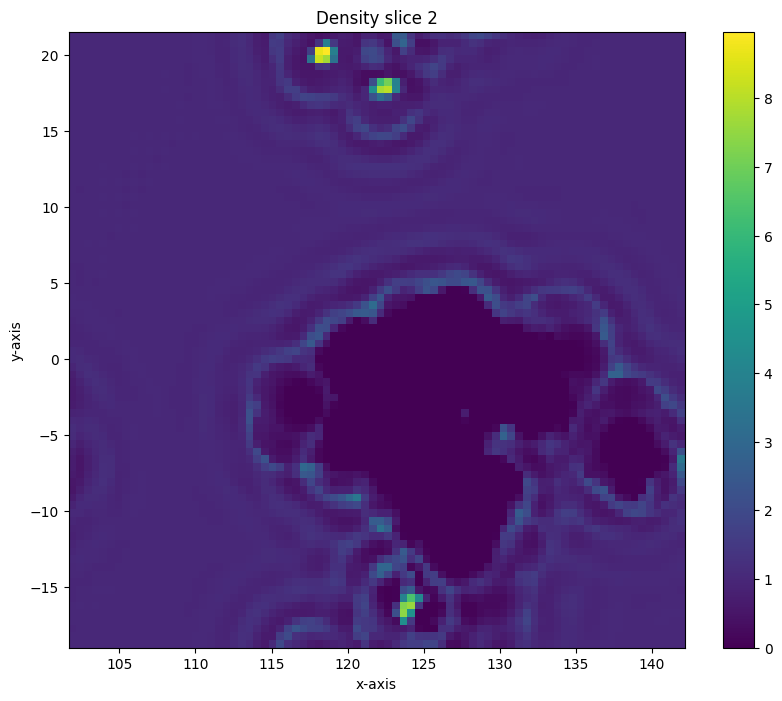

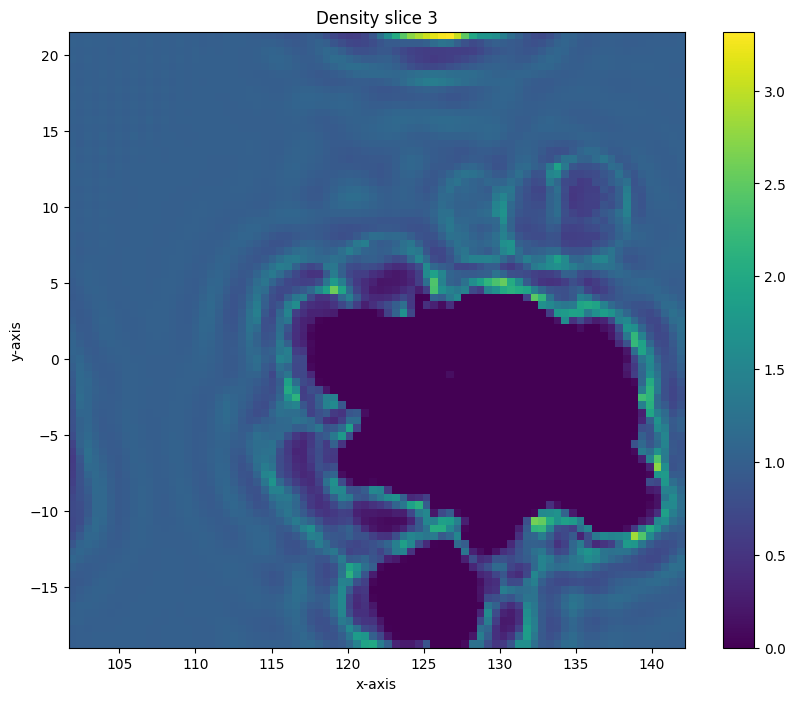

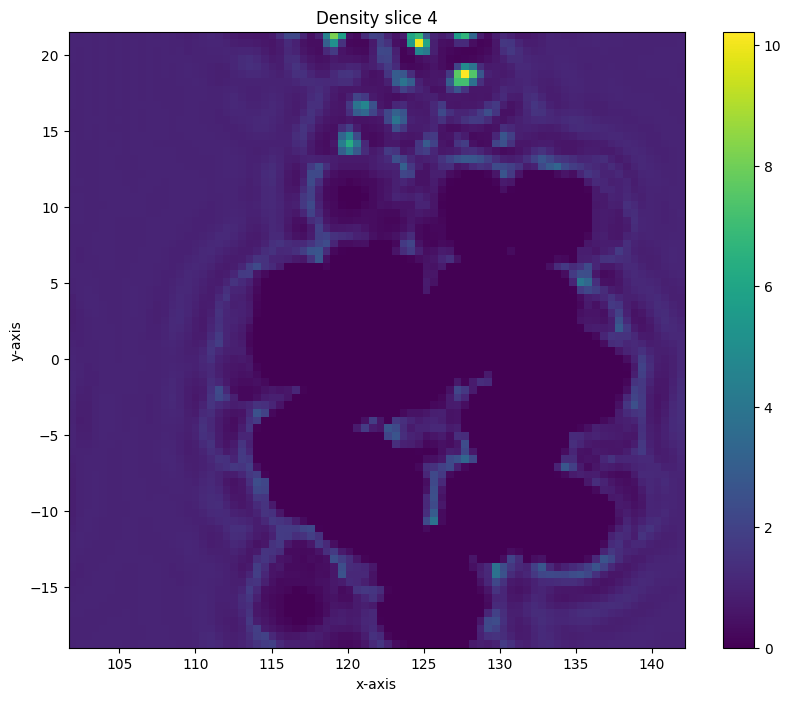

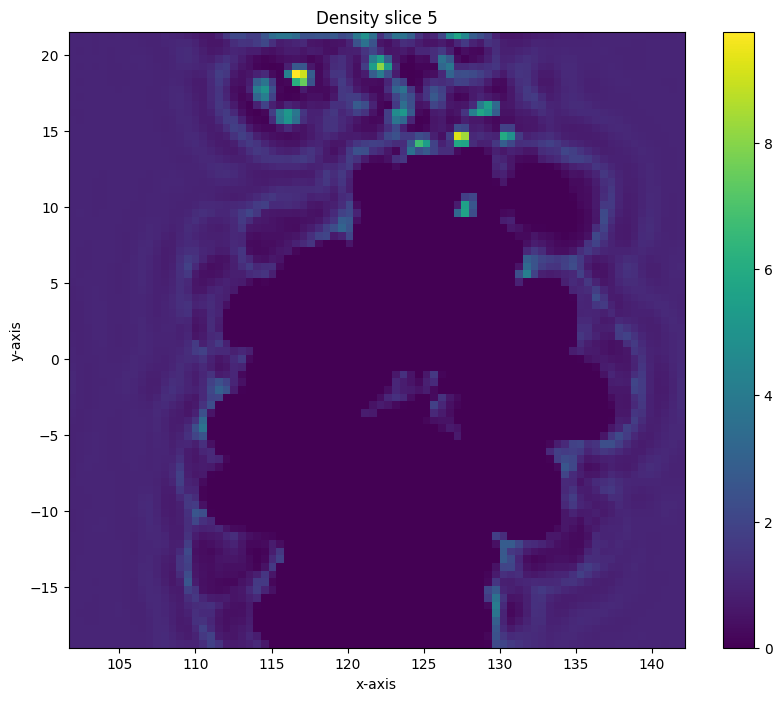

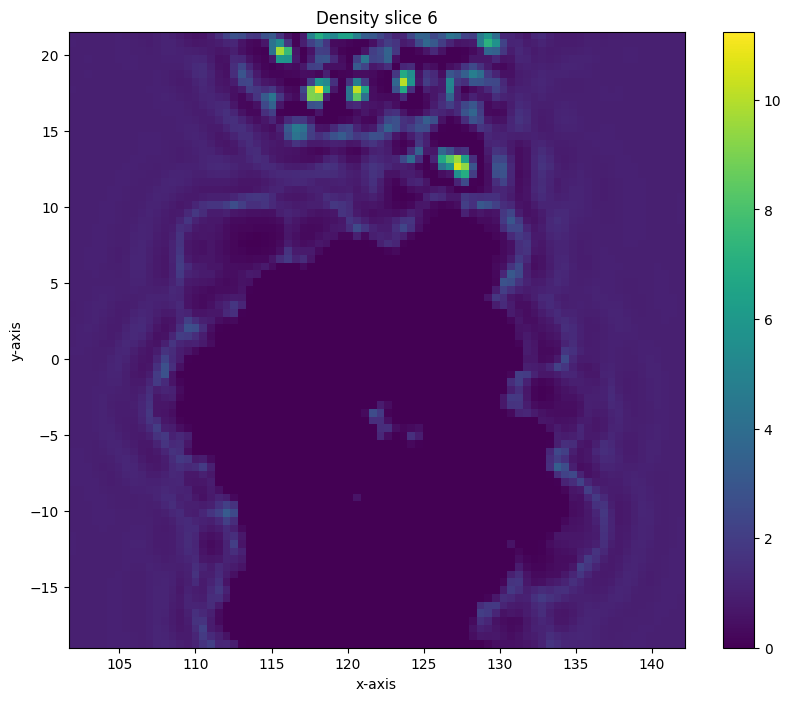

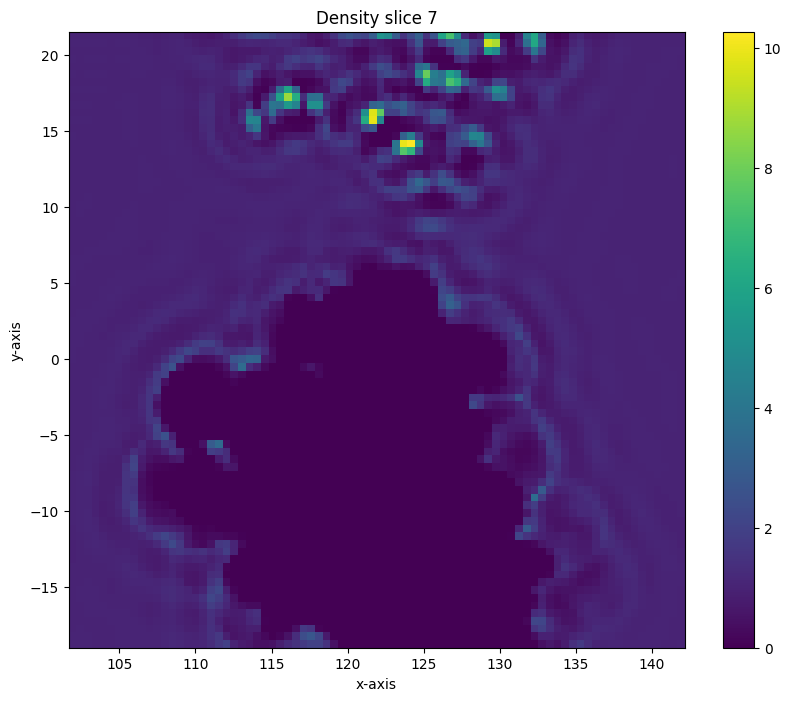

In [13]:
for c, canvas in enumerate(canvases_bd):
    canvas.draw(title=f"Density slice {c}")

### A third example starting with a 3D-RISM density file.

In [14]:
grid_dh = density_file_to_grid("../data/3D-RISM_densities/dehydratase/prot_3drism.O.1.dx")

In [15]:
print(density_origin(grid_dh))
print(density_point_boundaries(grid_dh))

[ -9.293  -6.514 -10.821]
[30.707 33.486 29.179]


Try slicing in the X direction.

In [16]:
points_dh = np.array([[8, 0, 0], [8, 1, 0], [8, 0, 1]]) + np.array([density_origin(grid_dh)] * 3)
canvases_dh = density_slices_by_plane_and_offsets(grid_dh, points=points_dh, offsets=np.linspace(8, 28, 3, dtype=int))

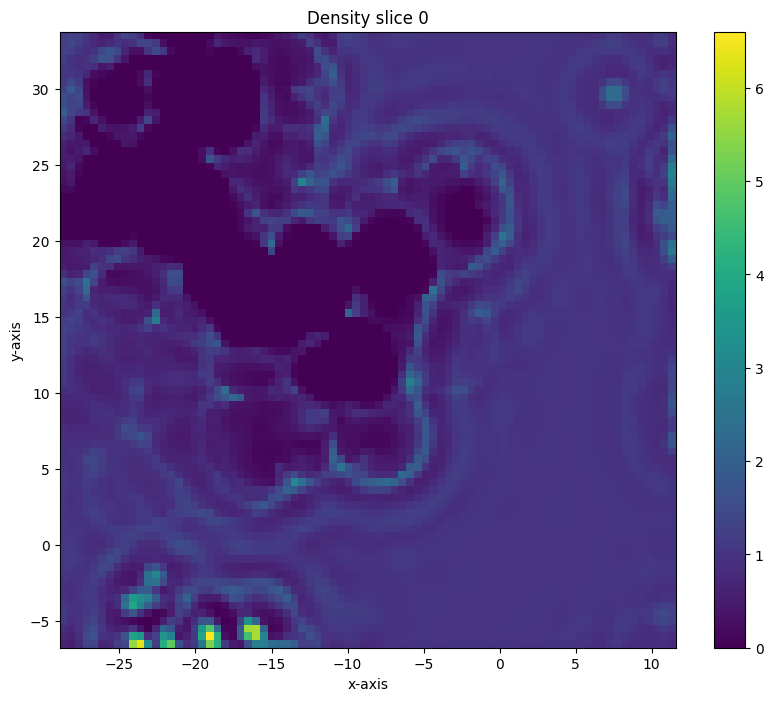

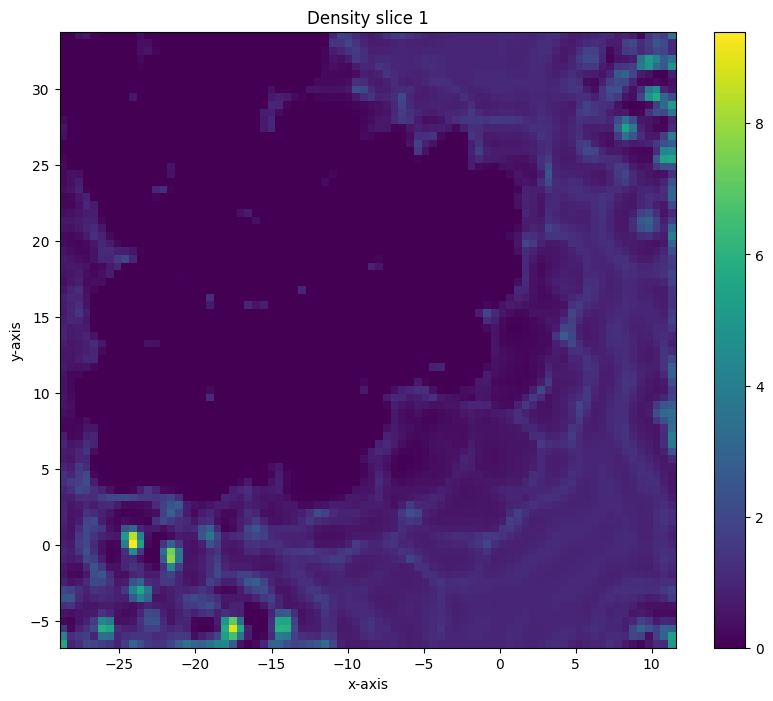

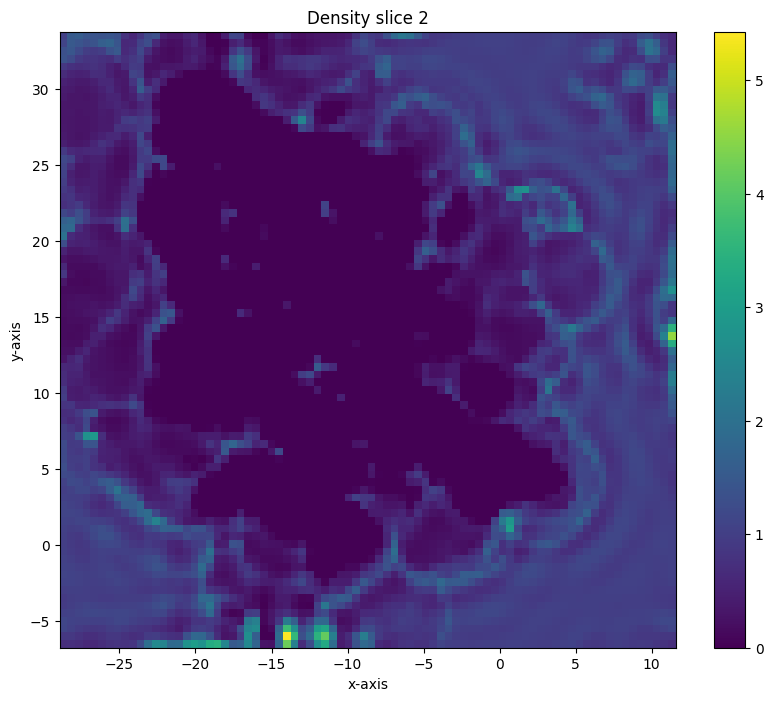

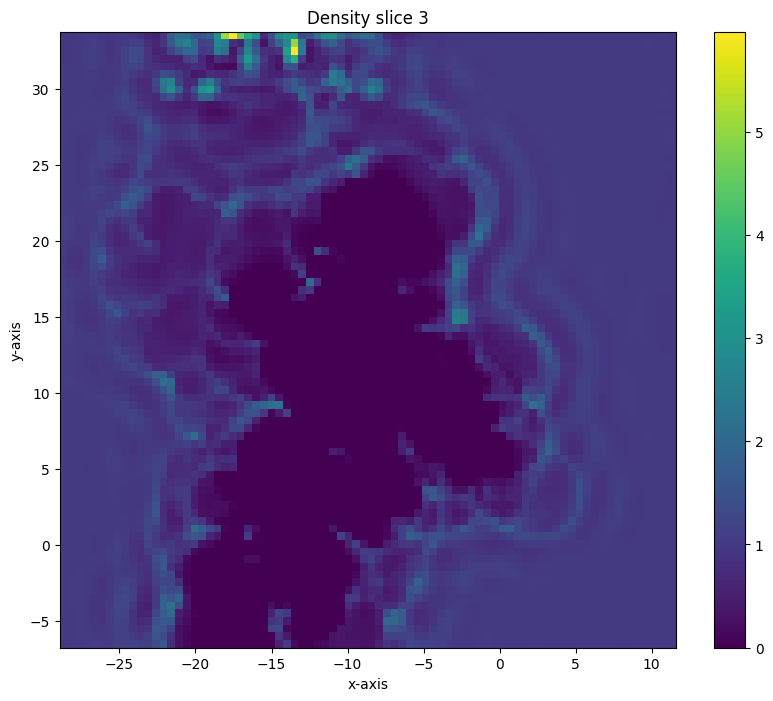

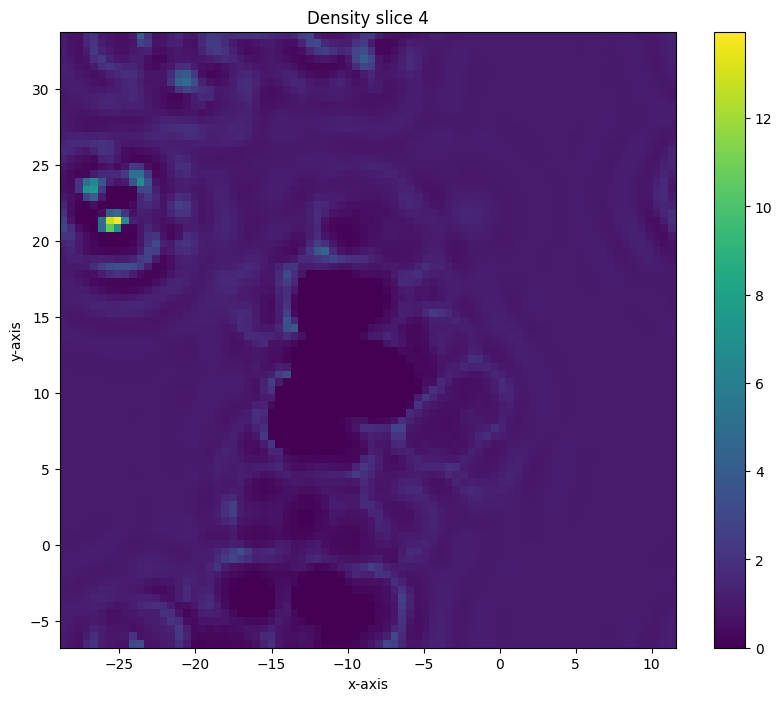

In [17]:
for c, canvas in enumerate(canvases_dh):
    canvas.draw(title=f"Density slice {c}")

In [18]:
# AQUAPOINTING

from pulser import Register
from pulser.devices import MockDevice, AnalogDevice
from pulser_simulation import QutipBackend


# choose the maximum detuning allowed
max_det = AnalogDevice.channel_objects[0].max_abs_detuning-1

# choose a blockade radius (in micrometers)
# which in turns defines a Rabi frequency
brad = 7
omega = AnalogDevice.rabi_from_blockade(brad)

# choose a pulse duration
T = 3000
pulse_settings = {"brad": brad, "omega": omega, "pulse_duration": T, "max_det": max_det}

In [19]:
def executor(pulse_seq, num_samples):
    sim = QutipBackend(pulse_seq)
    res = sim.run()
    return res.sample_final_state(num_samples)

In [22]:
for c in canvases:
    c.set_poisson_disk_lattice((2, 4))
    c.calculate_pubo_coefficients(2, [10, 30])
    c.force_lattice_size(5)

test_water_postions = analog.find_water_positions(canvases, executor, MockDevice, pulse_settings)
print(test_water_postions)

[[ 1.17114284 41.00988163 46.76      ]
 [12.75091742 42.97740918 46.76      ]
 [ 1.20864774 34.94720201 46.76      ]
 [ 6.95887335 40.08675082 46.76      ]
 [ 4.88989716 43.55045054 46.76      ]
 [ 3.30001296 43.20651245 56.76      ]
 [-0.11100671 37.22720794 56.76      ]
 [ 0.82408266 33.41192662 56.76      ]
 [ 1.01649368 27.15104598 56.76      ]
 [ 9.83664744 39.98798881 66.76      ]
 [14.88891764 40.92653991 66.76      ]
 [17.9900714  40.02907408 66.76      ]
 [14.6023324  37.01008276 66.76      ]
 [17.60585931 28.86954595 76.76      ]
 [22.62093114 30.66288499 76.76      ]
 [14.49325577 35.57482808 76.76      ]
 [19.58335702 33.7593532  76.76      ]]
